## Feature Selection algorithm

Feature selection is the process of automatically select a subset of features that are most relevant to the problem, to improve computational efficiency or reduce the generalization error of the model by removing irrelevant features or noise, which can be useful for algorithms that don't support regularization.

### Backward and forward selection

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv('./winequality-red.csv', sep=';')

In [3]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
df.rename(columns=lambda x: x.replace(" ", "_"), inplace=True)

In [5]:
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Train test split

In [6]:
X = df['alcohol']
y = df['quality']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

After splitting a single variable out of the DataFrame, it becomes a pandas series, hence we need to convert it back into a pandas DataFrame again, in order to index by key.

In [8]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

Variance and covariance is needed for calculating the coefficients of the regression model

In [9]:
alcohol_mean = X_train['alcohol'].mean()
quality_mean = y_train['quality'].mean()

In [10]:
alcohol_variance = round(sum((X_train['alcohol'] - alcohol_mean)**2), 2)
quality_variance = round(sum((y_train['quality'] - quality_mean)**2), 2)

In [11]:
covariance = round(sum((X_train['alcohol'] - alcohol_mean) * (y_train['quality'] - quality_mean)), 2)
b1 = covariance / alcohol_variance
b0 = quality_mean - b1 * alcohol_mean
print("Intercept (B0) : ", round(b0, 4), "Co-efficient (B1):", round(b1, 4))

Intercept (B0) :  1.6947 Co-efficient (B1): 0.377


After computing coefficients, it is necessary to predict the quality variable, which will test the quality of fit using R-squared value

In [12]:
y_test['y_pred'] = pd.DataFrame(b0 + b1*X_test['alcohol'])
ss_res = sum(((y_test['quality'] - y_test['y_pred'])**2))
ss_tot = sum((y_test['quality'] - y_test['quality'].mean())**2)
R_sqrd = 1 - (ss_res / ss_tot)
print("Test R-squared value", round(R_sqrd, 4))

Test R-squared value 0.1854


From the test R-squared value, we can conclude that there is no strong relationship between quality and alcohol variables in the wine data, as R-squared is less than 0.7.

### Example of multilinear regression - step-by-step methodology of model building

In [13]:
df.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

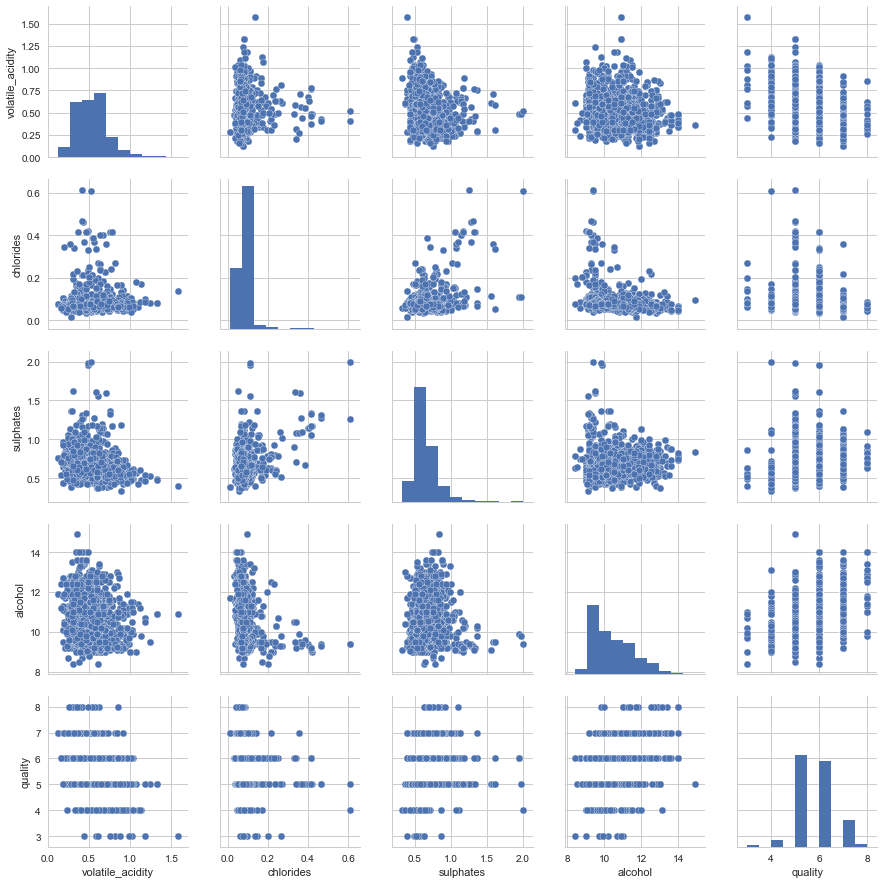

In [16]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

df = pd.read_csv('./winequality-red.csv', sep=';')
# Step for converting white space in columns to _ value for better handling
df.rename(columns=lambda x: x.replace(" ", "_"), inplace=True)
eda_columns = ['volatile_acidity', 'chlorides', 'sulphates', 'alcohol', 'quality']
# plots - pair plots
sns.set(style='whitegrid', context='notebook') # use xvar=eda_columns, yvar=eda_columns, if no label shown
sns.pairplot(df[eda_columns], size=2.5)
plt.show()

Lets inspect the correlation coefficients

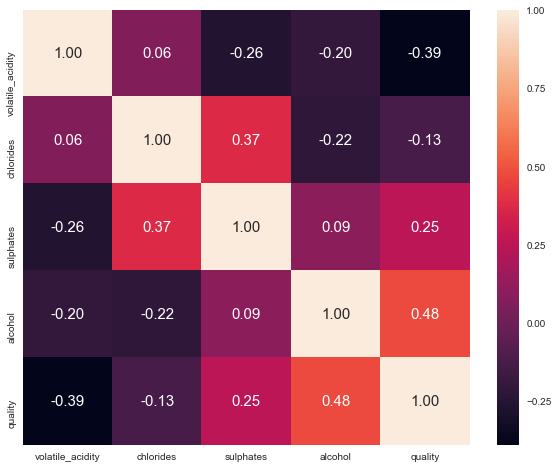

In [47]:
# Correlation coefficients
plt.figure(figsize=(10, 8))
corr_mat = np.corrcoef(df[eda_columns].values.T)
sns.set(font_scale=1)
#sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
sns.heatmap(corr_mat, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15},
                      yticklabels=eda_columns, xticklabels=eda_columns)
plt.show()

### Backward and forward selection

There are various methods to add or remove variables to determine the best possible model.
In the backward method, iterations start with considering all the variables and we will
remove variables one by one until all the prescribed statistics are met (such as no
insignificance and multi-collinearity, and so on). Finally, the overall statistic will be
checked, such as if R-squared value is > 0.7 , it is considered a good model, else reject it.

In the case of forward, we will start with no variables and keep on adding significant
variables until the overall model's fit improves.

In [76]:
df.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [112]:
columns = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol']
pdx = df[columns]
pdy = df['quality']

In [113]:
X_train, X_test, y_train, y_test = train_test_split(pdx, pdy, test_size=0.3, random_state=42)

Adding constant means creating an intercept variable. If we do not create an intercept, the coefficients will change accordingly

In [114]:
X_train_new = sm.add_constant(X_train)
X_test_new = sm.add_constant(X_test)
full_mod = sm.OLS(y_train, X_train_new)

The following code creates a model summary including R-squared, adjusted R-squared, and the p-value of independent variables

In [115]:
full_res = full_mod.fit()
print(full_res.summary())

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     56.90
Date:                Sun, 05 Aug 2018   Prob (F-statistic):          8.34e-100
Time:                        23:35:36   Log-Likelihood:                -1103.5
No. Observations:                1119   AIC:                             2231.
Df Residuals:                    1107   BIC:                             2291.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   17.9626 

The following code calculated VIF for all individual variables from first principles. Here we
are calculating the R-squared value for each variable and converting it into a VIF value:

In [116]:
print("Variance Inflation Factor")
cnames = X_train.columns
for i in np.arange(0, len(cnames)):
    xvars = list(cnames)
    yvar = xvars.pop(i)
    mod = sm.OLS(X_train[yvar], sm.add_constant(X_train_new[xvars]))
    res = mod.fit()
    vif = 1 / (1 - res.rsquared)
    print(yvar, round(vif, 3))
    

Variance Inflation Factor
fixed_acidity 7.189
volatile_acidity 1.824
citric_acid 3.139
residual_sugar 1.742
chlorides 1.463
free_sulfur_dioxide 1.973
total_sulfur_dioxide 2.205
density 5.902
pH 3.224
sulphates 1.428
alcohol 2.93


By looking into the preceding results, residual_sugar has highest the p-value of 0.668
and fixed_acidity has the highest VIF value of 7.189. In this situation, always first
remove the most insignificant variable, as insignificance is a more serious problem than
multi-collinearity, though both should be removed while reaching the final model.

Run the preceding code after removing the residual_sugar variable from the columns
list; we get the following result from iteration 2:

    
-  AIC: Merely reduced from 2231 to 2229.
-  Adjusted R-squared: Value did not change from 0.355.
-  Individual variable's p-value (P>|t|): Density is still coming in as most insignificant with a value of 0.713.
-  Individual variable's VIF: The fixed_acidity has the VIF ≥ 5. However, the density variable needs to be removed first, as priority is given to insignificance.

In this example, we have got the final results after iteration 5:
AIC: Reduced from 2231 from iteration 1 to 2225 in iteration 5.
Adjusted R-squared: Value changed to 0.356, which is a slight improvement but
not worth enough!
Individual variable's p-value (P>|t|): None of the variables are insignificant; all
values are less than 0.05.
Individual variable's VIF: All variables are less than five. Hence, we do not need
to remove any further variable based on VIF value.

We have got the answer that no strong relationship between the dependent and
independent variables exists. However, we can still predict based on the testing data and
calculate R-square to reconfirm.

The following code steps utilize the model to predict on testing data:

In [149]:
# Prediction of data
y_pred = full_res.predict(X_test_new)

# R-square calculation
rsqd = r2_score(y_test, y_pred)
print("Test R-squared value:", round(rsqd, 4))

Test R-squared value: 0.3514
